# Denoising using Lab41's model with a regression head

This notebook contains an example of loading an already trained version of Lab41's source separation model.

In [1]:
# Generic imports
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display

# Imports to play audio
from IPython.display import Audio, display

# Import Lab41's separation model
from magnolia.dnnseparate.L41_regression_model import L41RegressionModel

# Import utilities for using the model
from magnolia.utils.postprocessing import convert_preprocessing_parameters
from magnolia.features.preprocessing import undo_preprocessing
from magnolia.iterate.mix_iterator import MixIterator
from magnolia.utils.clustering_utils import l41_regression_clustering_separate, l41_regression_signal

In [2]:
model_params = {
    'alpha': 0.5,
    'nonlinearity': 'tanh',
    'layer_size': 600,
    'embedding_size': 40,
    'normalize': 'False'
}
signal_indices = [True, False]
uid_settings = '/local_data/magnolia/pipeline_data/date_2017_09_27_time_13_25/settings/assign_uids_LibriSpeech_UrbanSound8K.json'
model_save_base = '/local_data/magnolia/experiment_data/date_2017_11_02_time_21_52/aux/model_saves/l41_regression'

model_location = '/cpu:0'
mixes = ['/local_data/magnolia/pipeline_data/date_2017_09_27_time_13_25/settings/mixing_LibriSpeech_UrbanSound8K_test_out_of_sample.json']
from_disk = True
mix_number = 290

### Data iterator

Create a mix iterator that loops through the mixes one at a time.

In [3]:
mixer = MixIterator(mixes_settings_filenames=mixes,
                    batch_size=1,
                    from_disk=from_disk)

### Create and load a pretrained instance of Lab41's model with a regression head

Here an untrained model instance is created, and the pretrained weights are loaded

In [4]:
# get frequency dimension
frequency_dim = mixer.sample_dimensions()[0]

# get number of sources
settings = json.load(open(uid_settings))
uid_file = settings['output_file']
uid_csv = pd.read_csv(uid_file)
number_of_sources = uid_csv['uid'].max() + 1

In [5]:
model = L41RegressionModel(**model_params,
                           num_speakers=number_of_sources,
                           F=frequency_dim,
                           device=model_location)

model.load(model_save_base)

INFO:tensorflow:Restoring parameters from /local_data/magnolia/experiment_data/date_2017_11_02_time_21_52/aux/model_saves/l41_regression


In [6]:
assert(mix_number <= mixer.epoch_size())

def apply_binary_mask(mask, stft):
    return np.abs(stft)*mask*np.exp(1j*np.angle(stft))

settings = json.load(open(mixes[0]))

signal = settings['signals'][0]
preprocessing_settings = json.load(open(signal['preprocessing_settings']))
stft_args = preprocessing_settings['processing_parameters']['stft_args']
istft_args = convert_preprocessing_parameters(stft_args)
preemphasis_coeff = preprocessing_settings['processing_parameters']['preemphasis_coeff']
n_fft = 2048
if 'n_fft' in stft_args:
    n_fft = stft_args['n_fft']


for i in range(mix_number):
    spec, bin_masks, source_specs, uids, snrs = next(mixer)

model_spec = spec
spec = spec[0]
bin_masks = bin_masks[0]
source_specs = source_specs[0]
uids = uids[0]
snrs = snrs[0]

In [7]:
print('SNR of this mix: {}'.format(snrs))

SNR of this mix: -3.008138559431991


Display out the original sources and the mix

ORIGINALS
Mixed sample


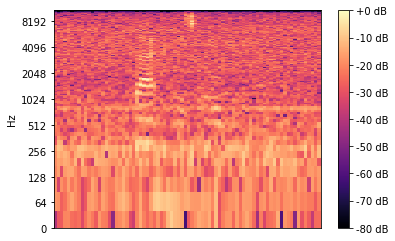

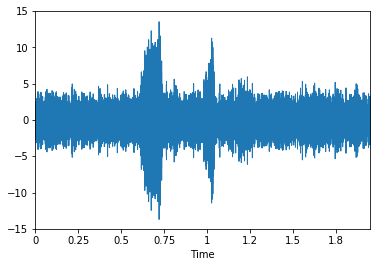

Sample for source 1


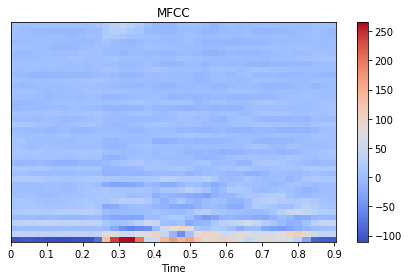

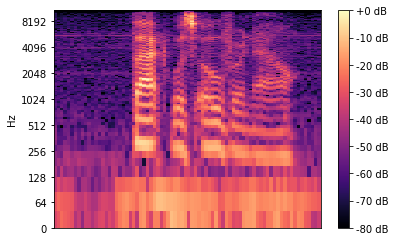

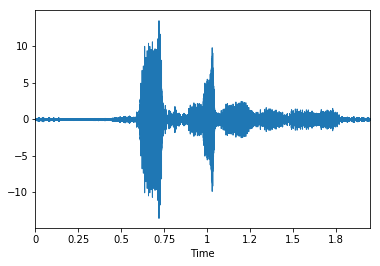

Sample for source 2


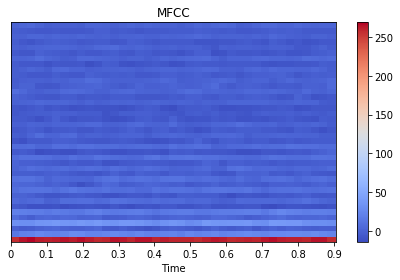

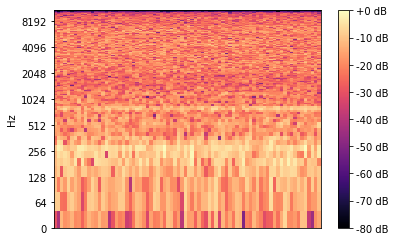

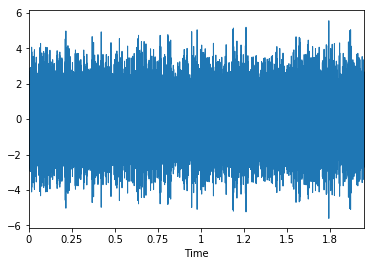

In [8]:
print('ORIGINALS')

y_mix = undo_preprocessing(spec, mixer.sample_length_in_bits(),
                           preemphasis_coeff=preemphasis_coeff,
                           istft_args=istft_args)

print('Mixed sample')
display(Audio(y_mix, rate=mixer.sample_rate()))

D = librosa.amplitude_to_db(spec, ref=np.max)
ax = librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

librosa.display.waveplot(y_mix[:-n_fft], sr=mixer.sample_rate())
plt.show()

for i, source_spec in enumerate(source_specs):
    y = undo_preprocessing(source_spec, mixer.sample_length_in_bits(),
                           preemphasis_coeff=preemphasis_coeff,
                           istft_args=istft_args)
    
    print('Sample for source {}'.format(i + 1))
    display(Audio(y[:-n_fft], rate=mixer.sample_rate()))
    
    mfccs = librosa.feature.mfcc(y=y[:-n_fft], sr=mixer.sample_rate(), n_mfcc=40)
    ax = librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()
    
    # max_along_time_bins = np.log(np.amax(np.abs(source_spec[6:, :]), axis=0))
    # m = max_along_time_bins - max_along_time_bins.mean() > -.5*max_along_time_bins.std()
    # source_spec_ = source_spec.copy()
    # source_spec_[:, ~m] = 0.0
    # D = librosa.amplitude_to_db(source_spec_, ref=np.max)
    # ax = librosa.display.specshow(D, y_axis='log')
    # plt.colorbar(format='%+2.0f dB')
    # plt.show()
    
    # plt.scatter(range(len(max_along_time_bins)), max_along_time_bins)
    # plt.show()
    
    D = librosa.amplitude_to_db(source_spec, ref=np.max)
    ax = librosa.display.specshow(D, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
    librosa.display.waveplot(y[:-n_fft], sr=mixer.sample_rate())
    plt.show()

IDEAL MASKS
Sample for source 1


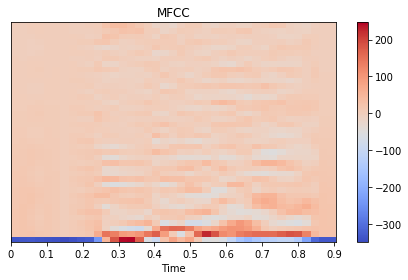

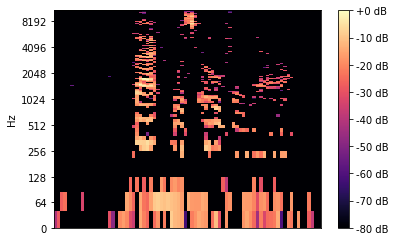

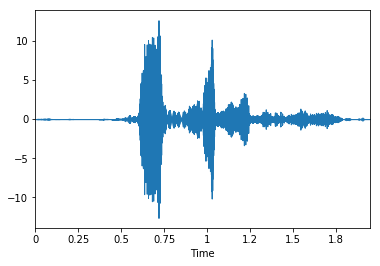

Sample for source 2


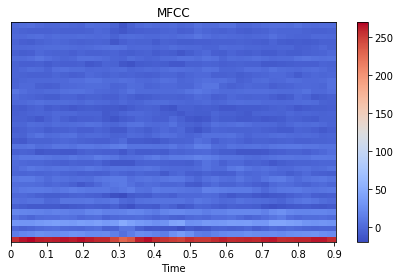

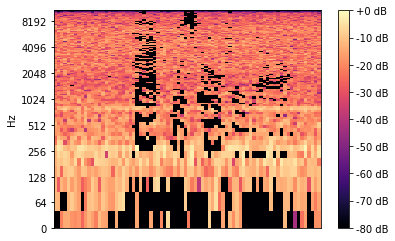

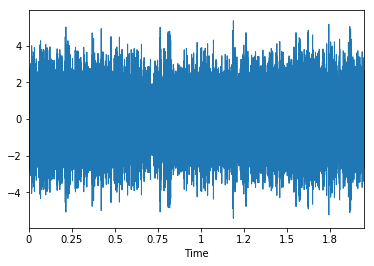

In [9]:
print('IDEAL MASKS')

for i, source_spec in enumerate(source_specs):
    bm = bin_masks[i].copy()
    y = undo_preprocessing(bm*spec,
                           mixer.sample_length_in_bits(),
                           preemphasis_coeff=preemphasis_coeff,
                           istft_args=istft_args)
    
    print('Sample for source {}'.format(i + 1))
    display(Audio(y[:-n_fft], rate=mixer.sample_rate()))
    
    mfccs = librosa.feature.mfcc(y=y[:-n_fft], sr=mixer.sample_rate(), n_mfcc=40)
    ax = librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()
    
    D = librosa.amplitude_to_db(bm*spec, ref=np.max)
    ax = librosa.display.specshow(D, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
    librosa.display.waveplot(y[:-n_fft], sr=mixer.sample_rate())
    plt.show()

Use the model and the clustering_separate function to separate the signal waveform into sources.

Separated sample for source 1


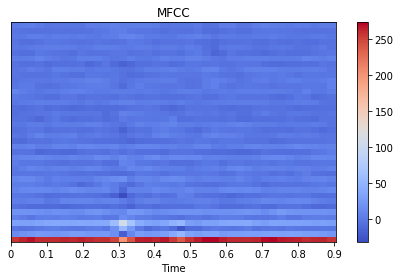

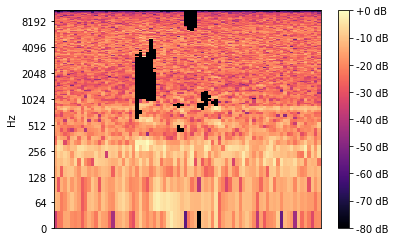

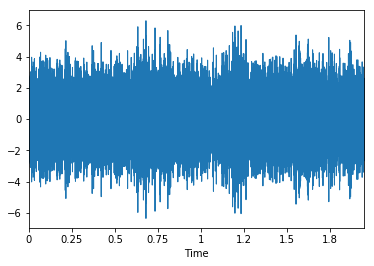

Separated sample for source 2


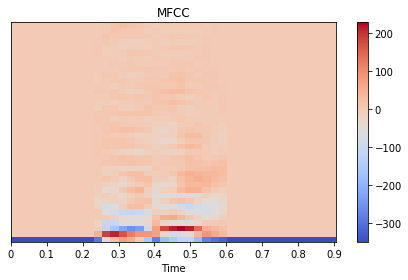

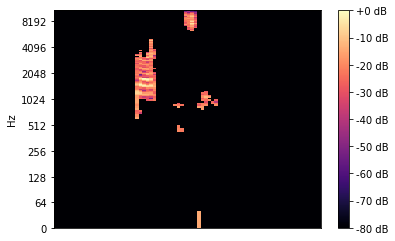

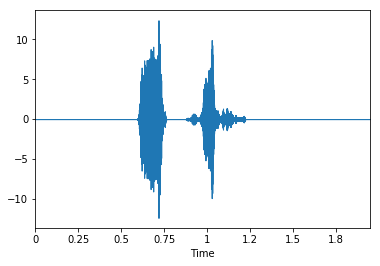

In [14]:
separated_source_specs = l41_regression_clustering_separate(model_spec, model, mixer.number_of_samples_in_mixes())

for i, source_spec in enumerate(separated_source_specs):
    y = undo_preprocessing(source_spec, mixer.sample_length_in_bits(),
                           preemphasis_coeff=preemphasis_coeff,
                           istft_args=istft_args)

    print('Separated sample for source {}'.format(i + 1))
    display(Audio(y[:-n_fft], rate=mixer.sample_rate()))
    
    mfccs = librosa.feature.mfcc(y=y[:-n_fft], sr=mixer.sample_rate(), n_mfcc=40)
    ax = librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCC')
    plt.tight_layout()
    plt.show()
    
    D = librosa.amplitude_to_db(source_spec, ref=np.max)
    ax = librosa.display.specshow(D, y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    
    librosa.display.waveplot(y[:-n_fft], sr=mixer.sample_rate())
    plt.show()

Separated sample for source 2


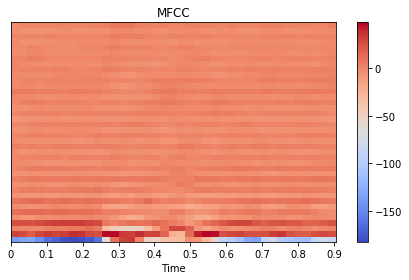

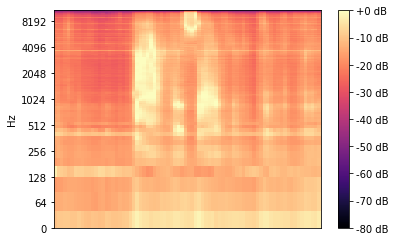

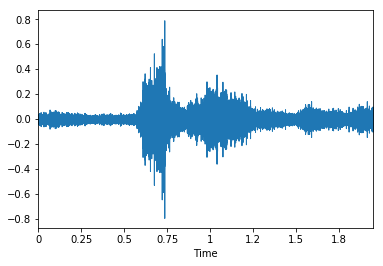

In [19]:
mag, phase = librosa.magphase(model_spec)

regression_signal = l41_regression_signal(model_spec, model)[:, :, :, 0]
regression_signal = regression_signal*phase

y = undo_preprocessing(regression_signal[0], mixer.sample_length_in_bits(),
                       preemphasis_coeff=preemphasis_coeff,
                       istft_args=istft_args)

print('Separated sample for source {}'.format(i + 1))
display(Audio(y[:-n_fft], rate=mixer.sample_rate()))
    
mfccs = librosa.feature.mfcc(y=y[:-n_fft], sr=mixer.sample_rate(), n_mfcc=40)
ax = librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()
    
D = librosa.amplitude_to_db(regression_signal[0], ref=np.max)
ax = librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()
    
librosa.display.waveplot(y[:-n_fft], sr=mixer.sample_rate())
plt.show()